In [1]:
import mne
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
def read_edf_hypnogram(hypnogram_file):
    """
    Read an EDF+ file containing hypnogram annotations and extract sleep stage information
    
    Parameters:
    -----------
    hypnogram_file : str
        Path to the EDF+ file containing hypnogram data
        
    Returns:
    --------
    hypno_data : dict
        Dictionary containing hypnogram data, window length, and time information
    """
    try:
        # First approach: Using pyedflib to directly access annotations
        f = pyedflib.EdfReader(hypnogram_file)
        
        # Check if the file has annotations
        n_annots = f.annotations_in_file
        print(f"Found {n_annots} annotations in file")
        
        if n_annots > 0:
            annotations = f.readAnnotations()
            onset = annotations[0]  # Onset times in seconds
            duration = annotations[1]  # Durations in seconds
            description = annotations[2]  # Annotation texts (sleep stages)
            
            # Calculate window length (time between consecutive annotations)
            if len(onset) > 1:
                window_length = onset[1] - onset[0]
                print(f"Detected window length: {window_length} seconds")
            else:
                window_length = duration[0]
                print(f"Only one annotation found. Using duration as window length: {window_length} seconds")
            
            # Convert to a more usable format (list of stages with their start times)
            stages = []
            times = []
            start_time = f.getStartdatetime()
            
            for i in range(len(onset)):
                stages.append(description[i])
                times.append(start_time + timedelta(seconds=float(onset[i])))
            
            f.close()
            return {
                'stages': stages,
                'times': times,
                'window_length_seconds': window_length,
                'onset': onset,
                'duration': duration
            }
        
        # If no annotations found with pyedflib, try MNE approach
        f.close()
        print("No annotations found with pyedflib, trying MNE...")
        
    except Exception as e:
        print(f"Error with pyedflib approach: {e}")
        print("Trying MNE approach...")
    
    # Second approach: Using MNE
    try:
        raw = mne.io.read_raw_edf(hypnogram_file, verbose=False)
        
        # Extract annotations
        annotations = raw.annotations
        
        if len(annotations) > 0:
            onset = annotations.onset  # Onset times in seconds
            duration = annotations.duration  # Durations in seconds
            description = annotations.description  # Annotation texts (sleep stages)
            
            # Calculate window length
            if len(onset) > 1:
                window_length = onset[1] - onset[0]
                print(f"Detected window length: {window_length} seconds")
            else:
                window_length = duration[0]
                print(f"Only one annotation found. Using duration as window length: {window_length} seconds")
            
            # Convert to a more usable format
            stages = list(description)
            start_time = raw.info['meas_date']
            times = [start_time + timedelta(seconds=float(o)) for o in onset]
            
            return {
                'stages': stages,
                'times': times,
                'window_length_seconds': window_length,
                'onset': onset,
                'duration': duration
            }
        else:
            print("No annotations found with MNE either.")
            return None
            
    except Exception as e:
        print(f"Error with MNE approach: {e}")
        
    # If all approaches fail, check if it's a standard EDF with hypnogram in a data channel
    try:
        f = pyedflib.EdfReader(hypnogram_file)
        channel_names = f.getSignalLabels()
        
        # Look for hypnogram-like channel names
        hypno_keywords = ['hypno', 'stage', 'sleep', 'stag']
        hypno_channels = [i for i, name in enumerate(channel_names) 
                         if any(keyword in name.lower() for keyword in hypno_keywords)]
        
        if hypno_channels:
            channel_idx = hypno_channels[0]
            print(f"Found potential hypnogram in channel: {channel_names[channel_idx]}")
            
            # Read the signal
            hypno_signal = f.readSignal(channel_idx)
            fs = f.getSampleFrequency(channel_idx)
            
            # Determine window length based on sampling frequency
            window_length = 30  # Default assumption for sleep staging (30 seconds)
            
            # Map numerical values to sleep stage labels if needed
            # This mapping may need adjustment based on your specific dataset
            stage_map = {
                0: 'Wake',
                1: 'N1',
                2: 'N2',
                3: 'N3',
                4: 'N3',  # Some older systems separate N3 into 3 and 4
                5: 'REM',
                6: 'Movement',
                -1: 'Unknown'
            }
            
            # Extract unique values as stages
            unique_stages = np.unique(hypno_signal)
            stages = [stage_map.get(int(s), f"Stage_{int(s)}") for s in unique_stages]
            
            print(f"Found stages: {stages}")
            print(f"Window length: {window_length} seconds (assumed standard)")
            
            f.close()
            return {
                'stages': stages,
                'window_length_seconds': window_length,
                'signal': hypno_signal,
                'sampling_frequency': fs
            }
            
        f.close()
        
    except Exception as e:
        print(f"Error checking for hypnogram channel: {e}")
    
    print("Could not extract hypnogram data from the file.")
    return None


In [3]:
def plot_hypnogram(hypno_data):
    """Plot the hypnogram for visualization"""
    if hypno_data is None:
        print("No hypnogram data to plot")
        return
    
    if 'signal' in hypno_data:
        # Plot signal-based hypnogram
        plt.figure(figsize=(15, 5))
        plt.plot(hypno_data['signal'])
        plt.title('Hypnogram')
        plt.ylabel('Sleep Stage')
        plt.xlabel('Samples')
        plt.grid(True)
        plt.show()
    else:
        # Plot annotation-based hypnogram
        stages = hypno_data['stages']
        times = hypno_data['times']
        onset = hypno_data['onset']
        duration = hypno_data['duration']
        
        # Map common sleep stage formats to numerical values for plotting
        stage_to_num = {
            'W': 0, 'Wake': 0, 'wakefulness': 0, 'WAKE': 0,
            'N1': 1, 'Stage 1': 1, 'S1': 1, 'NREM1': 1,
            'N2': 2, 'Stage 2': 2, 'S2': 2, 'NREM2': 2,
            'N3': 3, 'Stage 3': 3, 'S3': 3, 'NREM3': 3,
            'Stage 4': 3, 'S4': 3, 'NREM4': 3,  # Combining N3 and N4
            'R': 4, 'REM': 4, 'rapid eye movement': 4,
            'M': 5, 'MT': 5, 'Movement': 5, 'MOVEMENT': 5
        }
        
        # Convert stages to numbers for plotting
        numeric_stages = []
        for stage in stages:
            if stage in stage_to_num:
                numeric_stages.append(stage_to_num[stage])
            else:
                # Try to extract numeric value if the format is like "Sleep stage N3"
                if "Sleep stage W" in stage:
                    numeric_stages.append(0)
                elif "Sleep stage 1" in stage:
                    numeric_stages.append(1)
                elif "Sleep stage 2" in stage:
                    numeric_stages.append(2)
                elif "Sleep stage 3" in stage:
                    numeric_stages.append(3)
                elif "Sleep stage 4" in stage:
                    numeric_stages.append(3)  # Combine with N3
                elif "Sleep stage R" in stage or "REM" in stage:
                    numeric_stages.append(4)
                elif "Movement" in stage:
                    numeric_stages.append(5)
                else:
                    numeric_stages.append(-1)  # Unknown stage
        
        fig, ax = plt.subplots(figsize=(15, 5))
        
        # Determine if we need to use an offset for better visualization
        # If the first onset is very large, it's likely an offset from the start date
        min_onset = min(onset) if len(onset) > 0 else 0
        onset_adjusted = onset - min_onset if min_onset > 1000 else onset  # Only adjust if offset is significant
        
        # Plot each stage as a step function
        # Create x and y arrays for step plot
        x = []
        y = []
        
        for i in range(len(numeric_stages)):
            if i < len(onset) and i < len(duration):
                x.append(onset_adjusted[i])
                y.append(numeric_stages[i])
                # Add the end point of this stage
                if i+1 < len(onset):
                    x.append(onset_adjusted[i+1])
                    y.append(numeric_stages[i])
                else:  # Last stage
                    x.append(onset_adjusted[i] + duration[i])
                    y.append(numeric_stages[i])
        
        plt.step(x, y, where='post')
        
        # Set y-tick labels
        plt.yticks(
            [0, 1, 2, 3, 4, 5],
            ['Wake', 'N1', 'N2', 'N3/N4', 'REM', 'Movement']
        )
        
        # Improve x-axis formatting
        if len(times) > 0:
            # Format time axis labels nicely
            hours_range = max(onset_adjusted) / 3600  # Convert to hours
            if hours_range > 12:  # Long recording
                # Place ticks at hour intervals
                hour_ticks = np.arange(0, max(onset_adjusted) + 3600, 3600)
                plt.xticks(hour_ticks, [f"{int(h/3600)}h" for h in hour_ticks])
                plt.xlabel(f'Recording Time (hours) - Starting at {times[0].strftime("%Y-%m-%d %H:%M")})')
            else:  # Shorter recording
                # Place ticks at minute intervals
                minute_ticks = np.arange(0, max(onset_adjusted) + 600, 600)  # Every 10 minutes
                plt.xticks(minute_ticks, [f"{int(m/60)}m" for m in minute_ticks])
                plt.xlabel(f'Recording Time (minutes) - Starting at {times[0].strftime("%Y-%m-%d %H:%M")})')
        else:
            plt.xlabel('Time (seconds)')
        
        plt.title('Hypnogram')
        plt.ylabel('Sleep Stage')
        plt.grid(True)
        plt.gca().invert_yaxis()  # Standard hypnogram format (Wake at top)
        plt.show()
        
        # Add summary statistics
        if len(numeric_stages) > 0:
            stage_counts = {
                'Wake': numeric_stages.count(0),
                'N1': numeric_stages.count(1),
                'N2': numeric_stages.count(2),
                'N3/N4': numeric_stages.count(3),
                'REM': numeric_stages.count(4),
                'Movement': numeric_stages.count(5)
            }
            
            total_epochs = len(numeric_stages)
            window_len = hypno_data.get('window_length_seconds', 30)
            
            print("\nSleep Statistics:")
            print(f"Total recording time: {total_epochs * window_len / 3600:.2f} hours")
            for stage, count in stage_counts.items():
                if count > 0:
                    percentage = count / total_epochs * 100
                    time_hrs = count * window_len / 3600
                    print(f"{stage}: {count} epochs ({percentage:.1f}%) - {time_hrs:.2f} hours")

Found 154 annotations in file
Detected window length: 30630.0 seconds
Successfully extracted hypnogram data
Window length: 30630.0 seconds
Number of annotations/stages: 154

Sample of stage annotations:
Time: 1989-04-24 16:13:00, Stage: Sleep stage W
Time: 1989-04-25 00:43:30, Stage: Sleep stage 1
Time: 1989-04-25 00:45:30, Stage: Sleep stage 2
Time: 1989-04-25 00:52:00, Stage: Sleep stage 3
Time: 1989-04-25 00:52:30, Stage: Sleep stage 2


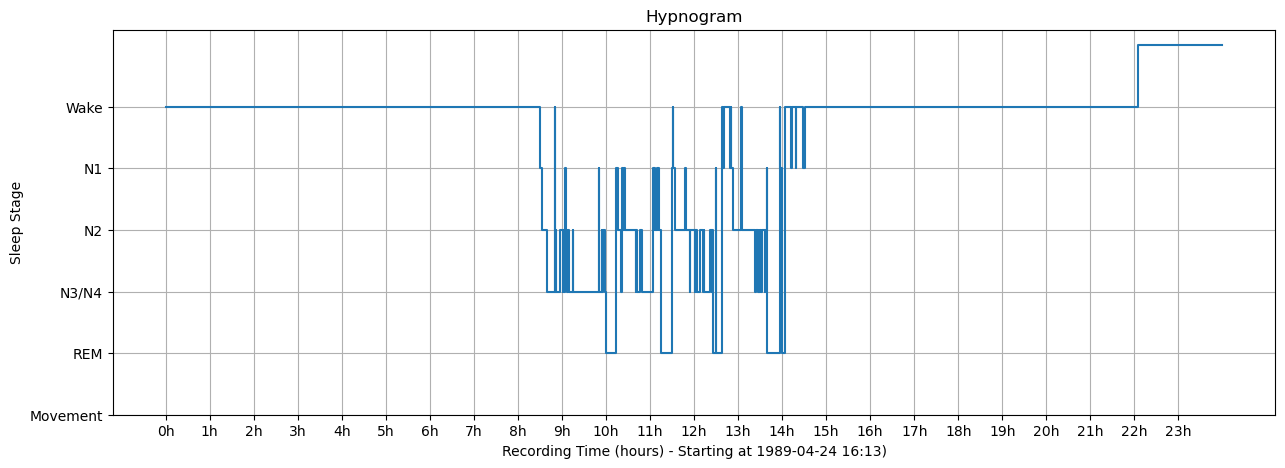


Sleep Statistics:
Total recording time: 1310.28 hours
Wake: 12 epochs (7.8%) - 102.10 hours
N1: 24 epochs (15.6%) - 204.20 hours
N2: 40 epochs (26.0%) - 340.33 hours
N3/N4: 71 epochs (46.1%) - 604.09 hours
REM: 6 epochs (3.9%) - 51.05 hours


In [7]:
# Replace with your EDF+ hypnogram file path
hypnogram_file = "raw data/SC4001EC-Hypnogram.edf"
    
# Read the hypnogram
hypno_data = read_edf_hypnogram(hypnogram_file)

if hypno_data:
    print(f"Successfully extracted hypnogram data")
    print(f"Window length: {hypno_data['window_length_seconds']} seconds")
    print(f"Number of annotations/stages: {len(hypno_data.get('stages', []))}")
        
    # Show first few annotations
    if 'stages' in hypno_data and len(hypno_data['stages']) > 0:
        print("\nSample of stage annotations:")
        for i in range(min(5, len(hypno_data['stages']))):
            if 'times' in hypno_data:
                print(f"Time: {hypno_data['times'][i]}, Stage: {hypno_data['stages'][i]}")
            else:
                print(f"Stage: {hypno_data['stages'][i]}")
        
        # Plot the hypnogram
    plot_hypnogram(hypno_data)
else:
        print("Failed to extract hypnogram data")